# **VFNet Model**

## Packages Version (Compatible stack)

In [3]:
import torch
import mmcv
import mmengine
import mmdet

print(f"PyTorch: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"CUDA Version: {torch.version.cuda}")
print(f"MMCV: {mmcv.__version__}")
print(f"MMEngine: {mmengine.__version__}")
print(f"MMDet: {mmdet.__version__}")

# Test CUDA
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    x = torch.randn(3, 3).cuda()
    print("CUDA tensor test: Success")

PyTorch: 2.1.0+cu121
CUDA Available: True
CUDA Version: 12.1
MMCV: 2.1.0
MMEngine: 0.10.3
MMDet: 3.3.0
GPU: NVIDIA GeForce MX250
CUDA tensor test: Success


## 1. Dataset Preparation Structure

First, organize our dataset in COCO format:
```
our_dataset/
├── annotations/
│   ├── train.json
│   └── val.json
├── train/
│   ├── image1.jpg
│   ├── image2.jpg
│   └── ...
└── val/
    ├── image1.jpg
    ├── image2.jpg
    └── ...
```

### 1.1 Verify COCO Dataset Structure

In [7]:
import os
import json

def verify_coco_structure():
    base_path = 'coco2017/'
    
    # Check required files
    required_files = [
        'annotations/instances_train2017.json',
        'annotations/instances_val2017.json',
        'train2017/',
        'val2017/'
    ]
    
    print("Checking COCO 2017 dataset structure...")
    for file_path in required_files:
        full_path = os.path.join(base_path, file_path)
        if os.path.exists(full_path):
            print(f"✓ Found: {file_path}")
        else:
            print(f"✗ Missing: {file_path}")
    
    # Check image counts
    train_images = len(os.listdir(os.path.join(base_path, 'train2017')))
    val_images = len(os.listdir(os.path.join(base_path, 'val2017')))
    
    print(f"\nTrain images: {train_images}")
    print(f"Val images: {val_images}")
    
    # Verify annotations
    with open(os.path.join(base_path, 'annotations/instances_train2017.json'), 'r') as f:
        train_ann = json.load(f)
        print(f"\nTrain annotations:")
        print(f"  - Images: {len(train_ann['images'])}")
        print(f"  - Annotations: {len(train_ann['annotations'])}")
        print(f"  - Categories: {len(train_ann['categories'])}")
    
    with open(os.path.join(base_path, 'annotations/instances_val2017.json'), 'r') as f:
        val_ann = json.load(f)
        print(f"\nVal annotations:")
        print(f"  - Images: {len(val_ann['images'])}")
        print(f"  - Annotations: {len(val_ann['annotations'])}")
        print(f"  - Categories: {len(val_ann['categories'])}")

verify_coco_structure()

Checking COCO 2017 dataset structure...
✓ Found: annotations/instances_train2017.json
✓ Found: annotations/instances_val2017.json
✓ Found: train2017/
✓ Found: val2017/

Train images: 118287
Val images: 5001

Train annotations:
  - Images: 118287
  - Annotations: 860001
  - Categories: 80

Val annotations:
  - Images: 5000
  - Annotations: 36781
  - Categories: 80


## 2. Complete Training Configuration

In [9]:
# Save complete COCO 2017 training config (with TensorBoard enabled)
config_content = '''
default_scope = 'mmdet'

# ====== Basic paths ======
data_root = 'coco2017/'            # Your COCO 2017 path
work_dir = './work_dirs_vfnet_coco' # <- TensorBoard logs will go here
num_classes = 80                    # COCO has 80 classes

# ====== Dataset settings - COCO 2017 ======
dataset_type = 'CocoDataset'

# ====== Model settings ======
model = dict(
    type='VFNet',
    data_preprocessor=dict(
        type='DetDataPreprocessor',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        bgr_to_rgb=True,
        pad_size_divisor=32
    ),
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')
    ),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        start_level=1,
        add_extra_convs='on_output',
        num_outs=5
    ),
    bbox_head=dict(
        type='VFNetHead',
        num_classes=num_classes,
        in_channels=256,
        stacked_convs=3,
        feat_channels=256,
        strides=[8, 16, 32, 64, 128],
        center_sampling=False,
        dcn_on_last_conv=False,
        use_atss=True,
        use_vfl=True,
        loss_cls=dict(
            type='VarifocalLoss',
            use_sigmoid=True,
            alpha=0.75,
            gamma=2.0,
            iou_weighted=True,
            loss_weight=1.0
        ),
        loss_bbox=dict(type='GIoULoss', loss_weight=1.5),
        loss_bbox_refine=dict(type='GIoULoss', loss_weight=2.0)
    ),
    train_cfg=dict(
        assigner=dict(type='ATSSAssigner', topk=9),
        allowed_border=-1,
        pos_weight=-1,
        debug=False
    ),
    test_cfg=dict(
        nms_pre=1000,
        min_bbox_size=0,
        score_thr=0.05,
        nms=dict(type='nms', iou_threshold=0.6),
        max_per_img=100
    )
)

# ====== Data pipeline ======
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(type='Resize', scale=(1333, 800), keep_ratio=True),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PackDetInputs')
]

val_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='Resize', scale=(1333, 800), keep_ratio=True),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(
        type='PackDetInputs',
        meta_keys=('img_id', 'img_path', 'ori_shape', 'img_shape', 'scale_factor')
    )
]
test_pipeline = val_pipeline

# ====== Dataloaders ======
train_dataloader = dict(
    batch_size=2,
    num_workers=4,
    persistent_workers=True,
    sampler=dict(type='DefaultSampler', shuffle=True),
    batch_sampler=dict(type='AspectRatioBatchSampler'),
    dataset=dict(
        type=dataset_type,
        data_root=data_root,
        ann_file='annotations/instances_train2017.json',
        data_prefix=dict(img='train2017/'),
        filter_cfg=dict(filter_empty_gt=True, min_size=32),
        pipeline=train_pipeline
    )
)

val_dataloader = dict(
    batch_size=1,
    num_workers=2,
    persistent_workers=True,
    drop_last=False,
    sampler=dict(type='DefaultSampler', shuffle=False),
    dataset=dict(
        type=dataset_type,
        data_root=data_root,
        ann_file='annotations/instances_val2017.json',
        data_prefix=dict(img='val2017/'),
        test_mode=True,
        pipeline=val_pipeline
    )
)
test_dataloader = val_dataloader

# ====== Evaluators ======
val_evaluator = dict(
    type='CocoMetric',
    ann_file=data_root + 'annotations/instances_val2017.json',
    metric='bbox',
    format_only=False,
    proposal_nums=(100, 1, 10)
)
test_evaluator = val_evaluator

# ====== Schedules ======
max_epochs = 12
train_cfg = dict(type='EpochBasedTrainLoop', max_epochs=max_epochs, val_interval=1)
val_cfg = dict(type='ValLoop')
test_cfg = dict(type='TestLoop')

optim_wrapper = dict(
    type='OptimWrapper',
    optimizer=dict(type='SGD', lr=0.0025, momentum=0.9, weight_decay=0.0001)
)

param_scheduler = [
    dict(type='LinearLR', start_factor=0.001, by_epoch=False, begin=0, end=500),
    dict(
        type='MultiStepLR',
        begin=0,
        end=max_epochs,
        by_epoch=True,
        milestones=[8, 11],
        gamma=0.1
    )
]

# ====== Logging, Hooks, TensorBoard ======
# log_processor optional but keeps nice epoch/iter formatting
log_processor = dict(by_epoch=True)

default_hooks = dict(
    timer=dict(type='IterTimerHook'),
    logger=dict(type='LoggerHook', interval=50),
    param_scheduler=dict(type='ParamSchedulerHook'),
    checkpoint=dict(type='CheckpointHook', interval=1),
    sampler_seed=dict(type='DistSamplerSeedHook'),
    # Draw sample visualizations to TensorBoard every N iters
    visualization=dict(type='DetVisualizationHook', draw=True, interval=500)
)

custom_hooks = [dict(type='EmptyCacheHook', after_iter=True)]

# Visualizer with TensorBoard backend
vis_backends = [
    dict(type='LocalVisBackend'),
    # You can set a subdir for TB logs; otherwise defaults under work_dir
    dict(type='TensorboardVisBackend')  # logs to work_dir by default
]
visualizer = dict(
    type='DetLocalVisualizer',
    vis_backends=vis_backends,
    name='visualizer'
)

# ====== Environment ======
env_cfg = dict(
    cudnn_benchmark=False,
    mp_cfg=dict(mp_start_method='fork', opencv_num_threads=0),
    dist_cfg=dict(backend='nccl'),
)

log_level = 'INFO'
load_from = None
resume_from = None

# For single GPU training
device = 'cuda:0'
'''

# Save config file
with open('vfnet_coco2017.py', 'w') as f:
    f.write(config_content)
print("✓ COCO 2017 training config saved!")



✓ COCO 2017 training config saved!


## 3. Training Script : It has a SMOKE mode

In [11]:
import os
from mmengine.config import Config
from mmengine.runner import Runner

def train_vfnet_coco(smoke=True, iters=10):
    # Load config
    cfg = Config.fromfile('vfnet_coco2017.py')

    print(f"Training VFNet on COCO 2017 with {cfg.num_classes} classes")

    # Work dir
    os.makedirs('./work_dirs_vfnet_coco', exist_ok=True)
    cfg.work_dir = './work_dirs_vfnet_coco'

    if smoke:
        # ---- FAST SMOKE TEST: 10 iterations, no eval ----
        cfg.train_cfg = dict(type='IterBasedTrainLoop', max_iters=iters, val_interval=0)
        # Make logging frequent so you see updates immediately
        if 'default_hooks' in cfg and 'logger' in cfg.default_hooks:
            cfg.default_hooks.logger.interval = 1
        # Keep visualization light or disable if you want it even faster:
        if 'default_hooks' in cfg and 'visualization' in cfg.default_hooks:
            cfg.default_hooks.visualization.interval = 0  # disable drawing for speed
            # or set a small interval like 5 to test image logging:
            # cfg.default_hooks.visualization.interval = 5

        # Simple LR scheduler to match iter-based loop
        cfg.param_scheduler = [
            dict(type='LinearLR', start_factor=0.001, by_epoch=False, begin=0, end=iters)
        ]

        # Skip validation config entirely
        cfg.val_cfg = None
        cfg.val_dataloader = None
        cfg.val_evaluator = None

        # Optional: smaller batch to start faster
        cfg.train_dataloader.batch_size = min(getattr(cfg.train_dataloader, 'batch_size', 2), 2)

        print(f"SMOKE mode: running {iters} iterations (no validation).")

    # Build runner
    runner = Runner.from_cfg(cfg)

    # Start training
    print("Starting training (smoke test)...")
    runner.train()
    print("✓ Smoke training completed!")

if __name__ == '__main__':
    # Run a quick 10-iteration smoke test
    train_vfnet_coco(smoke=True, iters=10)


Training VFNet on COCO 2017 with 80 classes
SMOKE mode: running 10 iterations (no validation).


D:\anaconda3\envs\vfnetbuild\lib\site-packages\torch\utils\cpp_extension.py:28: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import packaging  # type: ignore[attr-defined]


10/12 20:38:58 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: win32
    Python: 3.10.18 | packaged by Anaconda, Inc. | (main, Jun  5 2025, 13:08:55) [MSC v.1929 64 bit (AMD64)]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 1796345728
    GPU 0: NVIDIA GeForce MX250
    CUDA_HOME: D:\NVIDIA GPU Computing Toolkit\CUDA\v12.1
    MSVC: n/a, reason: fileno
    PyTorch: 2.1.0+cu121
    PyTorch compiling details: PyTorch built with:
  - C++ Version: 199711
  - MSVC 192930151
  - Intel(R) Math Kernel Library Version 2020.0.2 Product Build 20200624 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.1.1 (Git Hash 64f6bcbcbab628e96f33a62c3e975f8535a7bde4)
  - OpenMP 2019
  - LAPACK is enabled (usually provided by MKL)
  - CPU capability usage: AVX2
  - CUDA Runtime 12.1
  - NVCC architecture flags: -gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch

D:\anaconda3\envs\vfnetbuild\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


10/12 20:41:18 - mmengine - INFO - Epoch(train) [1][    1/58633]  lr: 2.5000e-06  eta: 0:10:17  time: 68.6301  data_time: 0.0139  memory: 3160  loss: 3.4217  loss_cls: 0.3965  loss_bbox: 1.2564  loss_bbox_rf: 1.7688
10/12 20:42:20 - mmengine - INFO - Epoch(train) [1][    2/58633]  lr: 2.8000e-04  eta: 0:08:42  time: 65.2961  data_time: 0.0937  memory: 3016  loss: 3.1219  loss_cls: 0.4120  loss_bbox: 1.1225  loss_bbox_rf: 1.5874
10/12 20:43:19 - mmengine - INFO - Epoch(train) [1][    3/58633]  lr: 5.5750e-04  eta: 0:07:24  time: 63.4596  data_time: 0.1223  memory: 3016  loss: 3.0377  loss_cls: 0.4336  loss_bbox: 1.0905  loss_bbox_rf: 1.5137
10/12 20:44:18 - mmengine - INFO - Epoch(train) [1][    4/58633]  lr: 8.3500e-04  eta: 0:06:12  time: 62.1328  data_time: 0.1347  memory: 3016  loss: 3.1372  loss_cls: 0.4080  loss_bbox: 1.1035  loss_bbox_rf: 1.6257
10/12 20:45:15 - mmengine - INFO - Epoch(train) [1][    5/58633]  lr: 1.1125e-03  eta: 0:05:05  time: 61.1277  data_time: 0.1378  memory

## 4. Training Monitor

Exploring log structure...

--- ./work_dirs_vfnet_coco\20251012_203854\vis_data\20251012_203854.json ---
Error reading: Extra data: line 2 column 1 (char 255)

--- ./work_dirs_vfnet_coco\20251012_203854\vis_data\scalars.json ---
Error reading: Extra data: line 2 column 1 (char 255)
Found latest log file: ./work_dirs_vfnet_coco\20251012_203854\vis_data\20251012_203854.json
Processed 10 log entries
Training metrics plot saved to: ./work_dirs_vfnet_coco\20251012_203854\vis_data\training_metrics.png


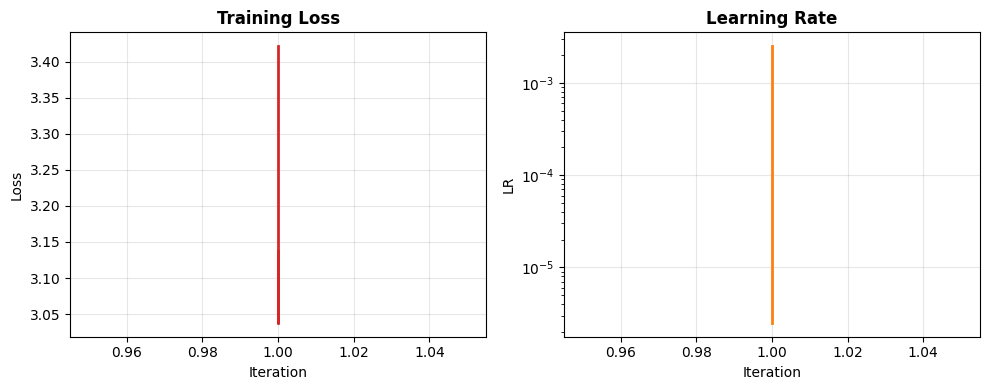

Found latest log file: ./work_dirs_vfnet_coco\20251012_203854\vis_data\20251012_203854.json

=== Training Summary ===
Log file: ./work_dirs_vfnet_coco\20251012_203854\vis_data\20251012_203854.json
Total log entries: 10
Max iteration: 10

Available metrics in logs:
  lr: 10 entries
  data_time: 10 entries
  loss: 10 entries
  loss_cls: 10 entries
  loss_bbox: 10 entries
  loss_bbox_rf: 10 entries
  time: 10 entries
  memory: 10 entries


In [13]:
import os
import json
import glob
import matplotlib.pyplot as plt
from datetime import datetime

def find_latest_log_file(work_dir='./work_dirs_vfnet_coco'):
    """Find the latest log file in the work directory structure"""
    # Look for all JSON files in vis_data folders
    vis_data_pattern = os.path.join(work_dir, '*', 'vis_data', '*.json')
    log_files = glob.glob(vis_data_pattern)
    
    if not log_files:
        raise FileNotFoundError(f"No log files found in {work_dir}/*/vis_data/")
    
    # Filter out non-log files and get the most recent based on folder timestamp
    valid_log_files = []
    for log_file in log_files:
        # Get the parent directory (run directory) to check timestamp
        run_dir = os.path.dirname(os.path.dirname(log_file))
        if any(name in log_file for name in ['scalars.json', '.json']):
            valid_log_files.append(log_file)
    
    if not valid_log_files:
        raise FileNotFoundError(f"No valid log files found in vis_data folders")
    
    # Sort by run directory modification time (newest first)
    valid_log_files.sort(key=lambda x: os.path.getmtime(os.path.dirname(os.path.dirname(x))), reverse=True)
    
    latest_log = valid_log_files[0]
    print(f"Found latest log file: {latest_log}")
    return latest_log

def parse_training_logs(log_file):
    """Parse training logs from the vis_data JSON format"""
    logs = []
    
    with open(log_file, 'r') as f:
        try:
            data = json.load(f)
            
            # Handle different JSON structures
            if isinstance(data, dict):
                # This is likely the scalars.json format
                for tag, values in data.items():
                    for entry in values:
                        epoch = entry.get('step', 0)  # Using step as epoch
                        if 'loss' in tag.lower():
                            logs.append({
                                'epoch': epoch,
                                'loss': entry.get('value', 0),
                                'tag': tag
                            })
                        elif 'mAP' in tag or 'accuracy' in tag.lower():
                            logs.append({
                                'epoch': epoch,
                                'coco/bbox_mAP': entry.get('value', 0),
                                'tag': tag
                            })
                        elif 'lr' in tag.lower():
                            logs.append({
                                'epoch': epoch,
                                'lr': entry.get('value', 0),
                                'tag': tag
                            })
            else:
                # This might be the line-based JSON format
                for line in data:
                    if isinstance(line, dict):
                        logs.append(line)
                        
        except json.JSONDecodeError:
            # Fallback: try reading as line-based JSON
            f.seek(0)
            for line in f:
                line = line.strip()
                if line:
                    try:
                        logs.append(json.loads(line))
                    except json.JSONDecodeError:
                        continue
    
    return logs

def plot_training_metrics(work_dir='./work_dirs_vfnet_coco'):
    try:
        # Find the latest log file automatically
        log_file = find_latest_log_file(work_dir)
        
        # Parse training logs
        logs = parse_training_logs(log_file)
        
        if not logs:
            print("No valid log entries found in the log file")
            return
        
        print(f"Processed {len(logs)} log entries")
        
        # Extract metrics with flexible field detection
        epochs, losses, lrs, maps, map50, map75 = [], [], [], [], [], []
        
        for entry in logs:
            # Extract epoch/step (try different field names)
            epoch = entry.get('epoch') or entry.get('step') or entry.get('iter')
            
            # Extract loss (try common loss field names and tags)
            loss = None
            if 'loss' in entry:
                loss = entry.get('loss')
            elif 'tag' in entry and 'loss' in entry['tag'].lower():
                loss = entry.get('value')
            elif 'train/loss' in entry:
                loss = entry.get('train/loss')
            
            # Extract learning rate
            lr = entry.get('lr') or entry.get('learning_rate')
            if lr is None and 'tag' in entry and 'lr' in entry['tag'].lower():
                lr = entry.get('value')
            
            # Extract mAP metrics
            bbox_map = None
            if 'coco/bbox_mAP' in entry:
                bbox_map = entry.get('coco/bbox_mAP')
            elif 'bbox_mAP' in entry:
                bbox_map = entry.get('bbox_mAP')
            elif 'tag' in entry and 'mAP' in entry['tag']:
                bbox_map = entry.get('value')
            
            bbox_map_50 = entry.get('coco/bbox_mAP_50') or entry.get('bbox_mAP_50')
            bbox_map_75 = entry.get('coco/bbox_mAP_75') or entry.get('bbox_mAP_75')
            
            # Store data if we have valid epoch and metrics
            if epoch is not None:
                if loss is not None:
                    epochs.append(epoch)
                    losses.append(loss)
                    if lr is not None:
                        lrs.append((epoch, lr))
                
                if bbox_map is not None:
                    maps.append((epoch, bbox_map))
                if bbox_map_50 is not None:
                    map50.append((epoch, bbox_map_50))
                if bbox_map_75 is not None:
                    map75.append((epoch, bbox_map_75))
        
        # Create plots
        num_plots = sum([bool(losses), bool(lrs), bool(maps)])
        if num_plots == 0:
            print("No plottable data found. Available keys in first log entry:")
            if logs:
                print(list(logs[0].keys()))
            return
        
        fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 4))
        if num_plots == 1:
            axes = [axes]
        
        plot_idx = 0
        
        # Plot loss
        if losses:
            ax = axes[plot_idx]
            ax.plot(epochs[:len(losses)], losses, color='tab:red', linewidth=2)
            ax.set_title('Training Loss', fontsize=12, fontweight='bold')
            ax.set_xlabel('Iteration')
            ax.set_ylabel('Loss')
            ax.grid(True, alpha=0.3)
            plot_idx += 1
        
        # Plot learning rate
        if lrs:
            ax = axes[plot_idx]
            epochs_lr, lr_values = zip(*lrs)
            ax.plot(epochs_lr, lr_values, color='tab:orange', linewidth=2)
            ax.set_title('Learning Rate', fontsize=12, fontweight='bold')
            ax.set_xlabel('Iteration')
            ax.set_ylabel('LR')
            ax.grid(True, alpha=0.3)
            ax.set_yscale('log')
            plot_idx += 1
        
        # Plot mAP
        if maps:
            ax = axes[plot_idx]
            epochs_map, map_values = zip(*maps)
            ax.plot(epochs_map, map_values, color='tab:green', linewidth=2, label='mAP')
            
            if map50:
                epochs_50, map50_values = zip(*map50)
                ax.plot(epochs_50, map50_values, color='tab:blue', linewidth=1, linestyle='--', label='mAP@50')
            
            if map75:
                epochs_75, map75_values = zip(*map75)
                ax.plot(epochs_75, map75_values, color='tab:purple', linewidth=1, linestyle='--', label='mAP@75')
            
            ax.set_title('Validation mAP', fontsize=12, fontweight='bold')
            ax.set_xlabel('Iteration')
            ax.set_ylabel('mAP')
            ax.grid(True, alpha=0.3)
            ax.legend()
        
        plt.tight_layout()
        
        # Save plot in the vis_data directory
        output_dir = os.path.dirname(log_file)
        plot_path = os.path.join(output_dir, 'training_metrics.png')
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        print(f"Training metrics plot saved to: {plot_path}")
        
        plt.show()
        
    except Exception as e:
        print(f"Error processing training metrics: {e}")
        import traceback
        traceback.print_exc()

def print_training_summary(work_dir='./work_dirs_vfnet_coco'):
    """Print a quick summary of the training progress"""
    try:
        log_file = find_latest_log_file(work_dir)
        logs = parse_training_logs(log_file)
        
        if logs:
            print(f"\n=== Training Summary ===")
            print(f"Log file: {log_file}")
            print(f"Total log entries: {len(logs)}")
            
            # Find max iteration
            iterations = [log.get('step') or log.get('iter') or log.get('epoch') for log in logs]
            iterations = [i for i in iterations if i is not None]
            if iterations:
                max_iter = max(iterations)
                print(f"Max iteration: {max_iter}")
            
            # Find best mAP if available
            maps = []
            for log in logs:
                map_val = log.get('coco/bbox_mAP') or log.get('bbox_mAP')
                if map_val is not None:
                    maps.append(map_val)
                elif 'tag' in log and 'mAP' in log['tag']:
                    maps.append(log.get('value', 0))
            
            if maps:
                print(f"Best mAP: {max(maps):.4f}")
            
            # Show available metrics
            print("\nAvailable metrics in logs:")
            metric_counts = {}
            for log in logs:
                for key in log.keys():
                    if key not in ['step', 'iter', 'epoch', 'tag']:
                        metric_counts[key] = metric_counts.get(key, 0) + 1
            
            for metric, count in metric_counts.items():
                print(f"  {metric}: {count} entries")
                
    except Exception as e:
        print(f"Error generating summary: {e}")

def explore_log_structure(work_dir='./work_dirs_vfnet_coco'):
    """Helper function to explore the log file structure"""
    print("Exploring log structure...")
    vis_data_pattern = os.path.join(work_dir, '*', 'vis_data', '*.json')
    log_files = glob.glob(vis_data_pattern)
    
    for log_file in sorted(log_files)[-2:]:  # Show last 2 runs
        print(f"\n--- {log_file} ---")
        try:
            with open(log_file, 'r') as f:
                data = json.load(f)
                if isinstance(data, dict):
                    print(f"Format: Dict with keys: {list(data.keys())}")
                    for key in list(data.keys())[:3]:  # Show first 3 metrics
                        values = data[key]
                        if values:
                            print(f"  {key}: {len(values)} entries, sample: {values[0]}")
                else:
                    print(f"Format: List with {len(data)} entries")
                    if data:
                        print(f"Sample entry: {data[0]}")
        except Exception as e:
            print(f"Error reading: {e}")

if __name__ == '__main__':
    # First, let's explore what's in your log files
    explore_log_structure()
    
    # Then plot the metrics
    plot_training_metrics()
    
    # Print summary
    print_training_summary()

## 5. Quick Test After Training

=== Checkpoint Information ===
Last checkpoint: D:\MyMasterDegreeJourney\Second year\Semester 1\Research methods in AI\work_dirs_vfnet_coco\epoch_1.pth
Found 1 checkpoint files:
  - epoch_1.pth (250.5 MB)

=== Testing Trained Model ===
✓ Using checkpoint from last_checkpoint file: D:\MyMasterDegreeJourney\Second year\Semester 1\Research methods in AI\work_dirs_vfnet_coco\epoch_1.pth
✓ Run directory: D:\MyMasterDegreeJourney\Second year\Semester 1\Research methods in AI\work_dirs_vfnet_coco
✓ Using checkpoint: epoch_1.pth
Loading model...
Loads checkpoint by local backend from path: D:\MyMasterDegreeJourney\Second year\Semester 1\Research methods in AI\work_dirs_vfnet_coco\epoch_1.pth
✓ Model loaded successfully on cuda:0
✓ Test image: coco2017/val2017/000000000139.jpg

Running inference...
✓ Detected 53 objects (0 with score >= 0.3)

=== Detection Details (score >= 0.3) ===
Total detections: 0

=== Creating Visualization ===
Visualization error: Visualizer.get_instance() missing 1 requ

Traceback (most recent call last):
  File "C:\Users\zohoo\AppData\Local\Temp\ipykernel_21016\1956661146.py", line 73, in visualize_result
    visualizer = VISUALIZERS.build(dict(type='DetLocalVisualizer'))
  File "D:\anaconda3\envs\vfnetbuild\lib\site-packages\mmengine\registry\registry.py", line 570, in build
    return self.build_func(cfg, *args, **kwargs, registry=self)
  File "D:\anaconda3\envs\vfnetbuild\lib\site-packages\mmengine\registry\build_functions.py", line 119, in build_from_cfg
    obj = obj_cls.get_instance(**args)  # type: ignore
TypeError: Visualizer.get_instance() missing 1 required positional argument: 'name'


Loads checkpoint by local backend from path: D:\MyMasterDegreeJourney\Second year\Semester 1\Research methods in AI\work_dirs_vfnet_coco\epoch_1.pth

=== Testing Different Thresholds ===

--- Threshold 0.1 ---
Detections with score >= 0.1: 0
Visualization error: Visualizer.get_instance() missing 1 required positional argument: 'name'

--- Threshold 0.3 ---


Traceback (most recent call last):
  File "C:\Users\zohoo\AppData\Local\Temp\ipykernel_21016\1956661146.py", line 73, in visualize_result
    visualizer = VISUALIZERS.build(dict(type='DetLocalVisualizer'))
  File "D:\anaconda3\envs\vfnetbuild\lib\site-packages\mmengine\registry\registry.py", line 570, in build
    return self.build_func(cfg, *args, **kwargs, registry=self)
  File "D:\anaconda3\envs\vfnetbuild\lib\site-packages\mmengine\registry\build_functions.py", line 119, in build_from_cfg
    obj = obj_cls.get_instance(**args)  # type: ignore
TypeError: Visualizer.get_instance() missing 1 required positional argument: 'name'


Detections with score >= 0.3: 0
Visualization error: Visualizer.get_instance() missing 1 required positional argument: 'name'

--- Threshold 0.5 ---


Traceback (most recent call last):
  File "C:\Users\zohoo\AppData\Local\Temp\ipykernel_21016\1956661146.py", line 73, in visualize_result
    visualizer = VISUALIZERS.build(dict(type='DetLocalVisualizer'))
  File "D:\anaconda3\envs\vfnetbuild\lib\site-packages\mmengine\registry\registry.py", line 570, in build
    return self.build_func(cfg, *args, **kwargs, registry=self)
  File "D:\anaconda3\envs\vfnetbuild\lib\site-packages\mmengine\registry\build_functions.py", line 119, in build_from_cfg
    obj = obj_cls.get_instance(**args)  # type: ignore
TypeError: Visualizer.get_instance() missing 1 required positional argument: 'name'


Detections with score >= 0.5: 0
Visualization error: Visualizer.get_instance() missing 1 required positional argument: 'name'

--- Threshold 0.7 ---


Traceback (most recent call last):
  File "C:\Users\zohoo\AppData\Local\Temp\ipykernel_21016\1956661146.py", line 73, in visualize_result
    visualizer = VISUALIZERS.build(dict(type='DetLocalVisualizer'))
  File "D:\anaconda3\envs\vfnetbuild\lib\site-packages\mmengine\registry\registry.py", line 570, in build
    return self.build_func(cfg, *args, **kwargs, registry=self)
  File "D:\anaconda3\envs\vfnetbuild\lib\site-packages\mmengine\registry\build_functions.py", line 119, in build_from_cfg
    obj = obj_cls.get_instance(**args)  # type: ignore
TypeError: Visualizer.get_instance() missing 1 required positional argument: 'name'


Detections with score >= 0.7: 0
Visualization error: Visualizer.get_instance() missing 1 required positional argument: 'name'

=== Comparison of Different Thresholds ===


Traceback (most recent call last):
  File "C:\Users\zohoo\AppData\Local\Temp\ipykernel_21016\1956661146.py", line 73, in visualize_result
    visualizer = VISUALIZERS.build(dict(type='DetLocalVisualizer'))
  File "D:\anaconda3\envs\vfnetbuild\lib\site-packages\mmengine\registry\registry.py", line 570, in build
    return self.build_func(cfg, *args, **kwargs, registry=self)
  File "D:\anaconda3\envs\vfnetbuild\lib\site-packages\mmengine\registry\build_functions.py", line 119, in build_from_cfg
    obj = obj_cls.get_instance(**args)  # type: ignore
TypeError: Visualizer.get_instance() missing 1 required positional argument: 'name'


✓ Comparison saved: D:\MyMasterDegreeJourney\Second year\Semester 1\Research methods in AI\work_dirs_vfnet_coco\threshold_comparison.jpg


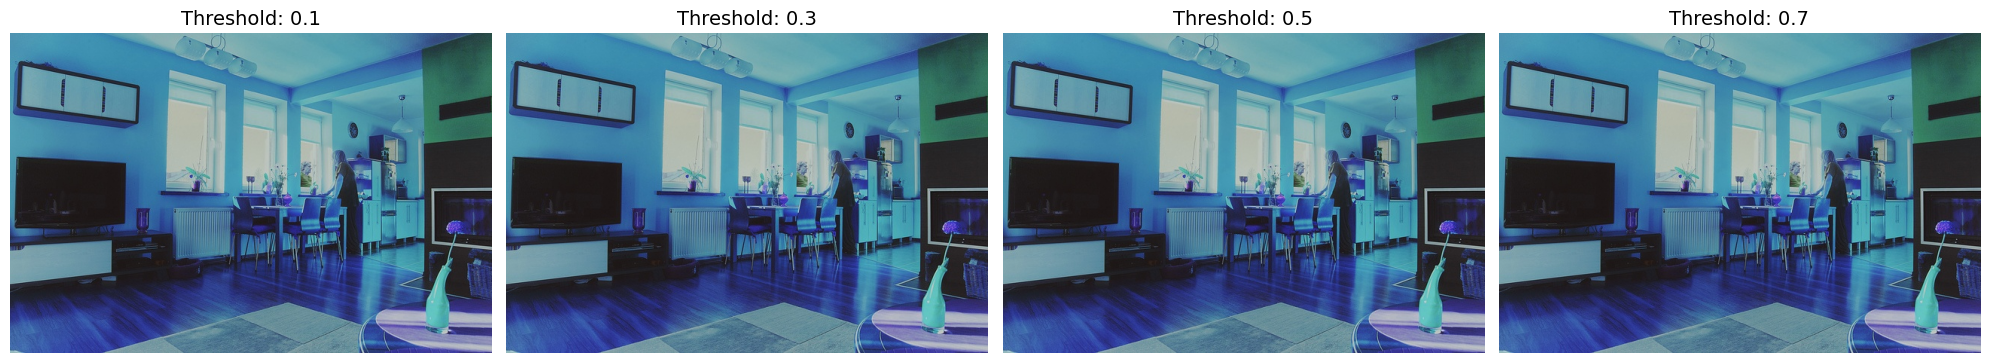


✓ Using checkpoint from last_checkpoint file: D:\MyMasterDegreeJourney\Second year\Semester 1\Research methods in AI\work_dirs_vfnet_coco\epoch_1.pth
Loads checkpoint by local backend from path: D:\MyMasterDegreeJourney\Second year\Semester 1\Research methods in AI\work_dirs_vfnet_coco\epoch_1.pth

=== Testing on 5 Images ===

[1/5] Processing: 000000000139.jpg
  Detections: 0
Visualization error: Visualizer.get_instance() missing 1 required positional argument: 'name'

[2/5] Processing: 000000000285.jpg


Traceback (most recent call last):
  File "C:\Users\zohoo\AppData\Local\Temp\ipykernel_21016\1956661146.py", line 73, in visualize_result
    visualizer = VISUALIZERS.build(dict(type='DetLocalVisualizer'))
  File "D:\anaconda3\envs\vfnetbuild\lib\site-packages\mmengine\registry\registry.py", line 570, in build
    return self.build_func(cfg, *args, **kwargs, registry=self)
  File "D:\anaconda3\envs\vfnetbuild\lib\site-packages\mmengine\registry\build_functions.py", line 119, in build_from_cfg
    obj = obj_cls.get_instance(**args)  # type: ignore
TypeError: Visualizer.get_instance() missing 1 required positional argument: 'name'


  Detections: 0
Visualization error: Visualizer.get_instance() missing 1 required positional argument: 'name'

[3/5] Processing: 000000000632.jpg


Traceback (most recent call last):
  File "C:\Users\zohoo\AppData\Local\Temp\ipykernel_21016\1956661146.py", line 73, in visualize_result
    visualizer = VISUALIZERS.build(dict(type='DetLocalVisualizer'))
  File "D:\anaconda3\envs\vfnetbuild\lib\site-packages\mmengine\registry\registry.py", line 570, in build
    return self.build_func(cfg, *args, **kwargs, registry=self)
  File "D:\anaconda3\envs\vfnetbuild\lib\site-packages\mmengine\registry\build_functions.py", line 119, in build_from_cfg
    obj = obj_cls.get_instance(**args)  # type: ignore
TypeError: Visualizer.get_instance() missing 1 required positional argument: 'name'


  Detections: 0
Visualization error: Visualizer.get_instance() missing 1 required positional argument: 'name'

[4/5] Processing: 000000000724.jpg


Traceback (most recent call last):
  File "C:\Users\zohoo\AppData\Local\Temp\ipykernel_21016\1956661146.py", line 73, in visualize_result
    visualizer = VISUALIZERS.build(dict(type='DetLocalVisualizer'))
  File "D:\anaconda3\envs\vfnetbuild\lib\site-packages\mmengine\registry\registry.py", line 570, in build
    return self.build_func(cfg, *args, **kwargs, registry=self)
  File "D:\anaconda3\envs\vfnetbuild\lib\site-packages\mmengine\registry\build_functions.py", line 119, in build_from_cfg
    obj = obj_cls.get_instance(**args)  # type: ignore
TypeError: Visualizer.get_instance() missing 1 required positional argument: 'name'


  Detections: 0
Visualization error: Visualizer.get_instance() missing 1 required positional argument: 'name'

[5/5] Processing: 000000000776.jpg


Traceback (most recent call last):
  File "C:\Users\zohoo\AppData\Local\Temp\ipykernel_21016\1956661146.py", line 73, in visualize_result
    visualizer = VISUALIZERS.build(dict(type='DetLocalVisualizer'))
  File "D:\anaconda3\envs\vfnetbuild\lib\site-packages\mmengine\registry\registry.py", line 570, in build
    return self.build_func(cfg, *args, **kwargs, registry=self)
  File "D:\anaconda3\envs\vfnetbuild\lib\site-packages\mmengine\registry\build_functions.py", line 119, in build_from_cfg
    obj = obj_cls.get_instance(**args)  # type: ignore
TypeError: Visualizer.get_instance() missing 1 required positional argument: 'name'


  Detections: 0
Visualization error: Visualizer.get_instance() missing 1 required positional argument: 'name'

=== Creating Grid Visualization ===
Could not create grid visualization: [Errno 2] No such file or directory: 'D:\\MyMasterDegreeJourney\\Second year\\Semester 1\\Research methods in AI\\work_dirs_vfnet_coco\\multi_test_1_000000000139.jpg'


Traceback (most recent call last):
  File "C:\Users\zohoo\AppData\Local\Temp\ipykernel_21016\1956661146.py", line 73, in visualize_result
    visualizer = VISUALIZERS.build(dict(type='DetLocalVisualizer'))
  File "D:\anaconda3\envs\vfnetbuild\lib\site-packages\mmengine\registry\registry.py", line 570, in build
    return self.build_func(cfg, *args, **kwargs, registry=self)
  File "D:\anaconda3\envs\vfnetbuild\lib\site-packages\mmengine\registry\build_functions.py", line 119, in build_from_cfg
    obj = obj_cls.get_instance(**args)  # type: ignore
TypeError: Visualizer.get_instance() missing 1 required positional argument: 'name'


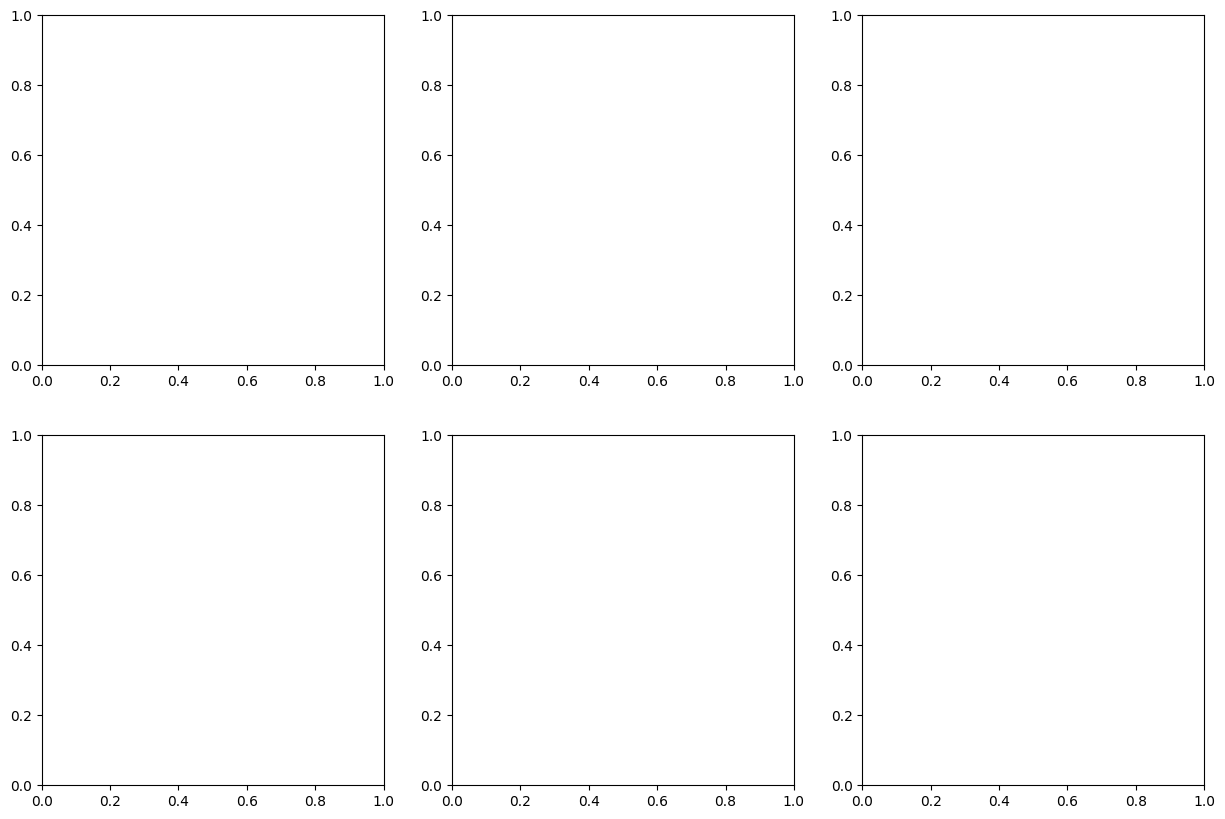

In [15]:
import os
import glob
import numpy as np
from mmengine.config import Config
from mmdet.apis import init_detector, inference_detector
from mmdet.registry import VISUALIZERS
import mmcv
from IPython.display import Image as IPImage, display
import matplotlib.pyplot as plt

def find_latest_checkpoint(work_dir='./work_dirs_vfnet_coco'):
    """Find the latest checkpoint using last_checkpoint file"""
    last_checkpoint_file = os.path.join(work_dir, 'last_checkpoint')
    
    # First try to read from last_checkpoint file
    if os.path.exists(last_checkpoint_file):
        with open(last_checkpoint_file, 'r') as f:
            checkpoint_path = f.read().strip()
            if os.path.exists(checkpoint_path):
                print(f"✓ Using checkpoint from last_checkpoint file: {checkpoint_path}")
                return checkpoint_path
            else:
                print(f"Warning: Checkpoint in last_checkpoint file not found: {checkpoint_path}")
    
    # Fallback: look for checkpoint files directly
    checkpoint_pattern = os.path.join(work_dir, '*.pth')
    checkpoint_files = glob.glob(checkpoint_pattern)
    
    if not checkpoint_files:
        raise FileNotFoundError(f"No checkpoint files found in {work_dir}")
    
    # Sort by modification time (newest first)
    checkpoint_files.sort(key=os.path.getmtime, reverse=True)
    
    # Prefer best checkpoint if available, otherwise latest
    best_checkpoints = [ckpt for ckpt in checkpoint_files if 'best' in ckpt.lower()]
    if best_checkpoints:
        latest_checkpoint = best_checkpoints[0]
        print(f"Using best checkpoint: {latest_checkpoint}")
    else:
        latest_checkpoint = checkpoint_files[0]
        print(f"Using latest checkpoint: {latest_checkpoint}")
    
    return latest_checkpoint

def get_checkpoint_info(work_dir='./work_dirs_vfnet_coco'):
    """Get information about available checkpoints"""
    print("=== Checkpoint Information ===")
    
    # Check last_checkpoint file
    last_checkpoint_file = os.path.join(work_dir, 'last_checkpoint')
    if os.path.exists(last_checkpoint_file):
        with open(last_checkpoint_file, 'r') as f:
            last_checkpoint = f.read().strip()
            print(f"Last checkpoint: {last_checkpoint}")
    
    # List all checkpoints
    checkpoint_pattern = os.path.join(work_dir, '*.pth')
    checkpoint_files = glob.glob(checkpoint_pattern)
    
    if checkpoint_files:
        print(f"Found {len(checkpoint_files)} checkpoint files:")
        for checkpoint in sorted(checkpoint_files):
            size_mb = os.path.getsize(checkpoint) / (1024 * 1024)
            print(f"  - {os.path.basename(checkpoint)} ({size_mb:.1f} MB)")
    else:
        print("No checkpoint files found")

def visualize_result(result, test_img_path, model, output_file, score_thr=0.3):
    """Create and display visualization"""
    try:
        # Initialize visualizer
        visualizer = VISUALIZERS.build(dict(type='DetLocalVisualizer'))
        visualizer.dataset_meta = model.dataset_meta
        
        # Load image
        img = mmcv.imread(test_img_path)
        
        # Create visualization
        visualizer.add_datasample(
            'result',
            img,
            data_sample=result,
            draw_gt=False,
            show=False,
            out_file=output_file,
            pred_score_thr=score_thr
        )
        
        print(f"✓ Visualization saved at: {output_file}")
        
        # Display in Jupyter
        try:
            display(IPImage(filename=output_file))
        except:
            print(f"Could not display image inline. Please open: {output_file}")
            
        return output_file
        
    except Exception as e:
        print(f"Visualization error: {e}")
        import traceback
        traceback.print_exc()
        return None

def print_detection_details(result, model, score_thr=0.3):
    """Print detailed detection information"""
    if hasattr(result, 'pred_instances'):
        scores = result.pred_instances.scores.cpu().numpy()
        labels = result.pred_instances.labels.cpu().numpy()
        bboxes = result.pred_instances.bboxes.cpu().numpy()
        
        # Filter by threshold
        confident_mask = scores >= score_thr
        confident_scores = scores[confident_mask]
        confident_labels = labels[confident_mask]
        confident_bboxes = bboxes[confident_mask]
        
        print(f"\n=== Detection Details (score >= {score_thr}) ===")
        print(f"Total detections: {len(confident_scores)}")
        
        if len(confident_scores) > 0:
            # Sort by score (descending)
            sorted_indices = np.argsort(confident_scores)[::-1]
            
            print("\nTop 10 Detections:")
            for i, idx in enumerate(sorted_indices[:10]):
                class_id = confident_labels[idx]
                class_name = model.dataset_meta['classes'][class_id]
                score = confident_scores[idx]
                bbox = confident_bboxes[idx]
                x1, y1, x2, y2 = bbox
                w, h = x2 - x1, y2 - y1
                
                print(f"  {i+1}. {class_name}: {score:.3f}")
                print(f"      BBox: [{x1:.1f}, {y1:.1f}, {x2:.1f}, {y2:.1f}] (W:{w:.1f}, H:{h:.1f})")
            
            # Class distribution
            print("\nClass Distribution:")
            unique, counts = np.unique(confident_labels, return_counts=True)
            for cls_id, count in sorted(zip(unique, counts), key=lambda x: x[1], reverse=True):
                class_name = model.dataset_meta['classes'][cls_id]
                print(f"  - {class_name}: {count}")
            
            # Score statistics
            print(f"\nScore Statistics:")
            print(f"  Mean: {confident_scores.mean():.3f}")
            print(f"  Max: {confident_scores.max():.3f}")
            print(f"  Min: {confident_scores.min():.3f}")
            print(f"  Std: {confident_scores.std():.3f}")

def test_trained_model(config_path='vfnet_coco2017.py', 
                      test_img_path='coco2017/val2017/000000000139.jpg',
                      score_thr=0.3,
                      device='cuda:0'):
    """Test the latest trained VFNet model on a sample validation image."""
    
    try:
        # === Load config ===
        if not os.path.exists(config_path):
            raise FileNotFoundError(f"Config file not found: {config_path}")
        
        cfg = Config.fromfile(config_path)
        
        # === Find latest checkpoint ===
        checkpoint_path = find_latest_checkpoint()
        
        # Get the run directory from checkpoint path
        run_dir = os.path.dirname(checkpoint_path)
        print(f"✓ Run directory: {run_dir}")
        print(f"✓ Using checkpoint: {os.path.basename(checkpoint_path)}")

        # === Load model ===
        print("Loading model...")
        model = init_detector(cfg, checkpoint_path, device=device)
        print(f"✓ Model loaded successfully on {device}")

        # === Check test image exists ===
        if not os.path.exists(test_img_path):
            # Try alternative paths
            alt_paths = [
                test_img_path,
                os.path.join('data', test_img_path),
                os.path.basename(test_img_path),
                '000000000139.jpg',
            ]
            
            found = False
            for alt_path in alt_paths:
                if os.path.exists(alt_path):
                    test_img_path = alt_path
                    found = True
                    break
            
            if not found:
                # Create a list of available images
                possible_dirs = ['coco2017/val2017', 'data/coco/val2017', 'val2017']
                for img_dir in possible_dirs:
                    if os.path.exists(img_dir):
                        images = glob.glob(os.path.join(img_dir, '*.jpg'))
                        if images:
                            test_img_path = images[0]
                            print(f"Using first available image: {test_img_path}")
                            found = True
                            break
            
            if not found:
                raise FileNotFoundError(f"Test image not found and no alternatives available")
        
        print(f"✓ Test image: {test_img_path}")

        # === Run inference ===
        print("\nRunning inference...")
        result = inference_detector(model, test_img_path)
        
        # Count detections
        if hasattr(result, 'pred_instances'):
            num_dets = len(result.pred_instances)
            scores = result.pred_instances.scores.cpu().numpy()
            confident_dets = sum(scores >= score_thr)
            print(f"✓ Detected {num_dets} objects ({confident_dets} with score >= {score_thr})")
        
        # Print detailed detection info
        print_detection_details(result, model, score_thr)

        # === Visualization ===
        print("\n=== Creating Visualization ===")
        img_name = os.path.splitext(os.path.basename(test_img_path))[0]
        output_file = os.path.join(run_dir, f'test_result_{img_name}.jpg')
        
        visualize_result(result, test_img_path, model, output_file, score_thr)

        # === Print model info ===
        print(f"\n=== Model Information ===")
        print(f"Model: {cfg.model.type}")
        print(f"Backbone: {cfg.model.backbone.type}")
        if hasattr(cfg, 'num_classes'):
            print(f"Number of classes: {cfg.num_classes}")
        print(f"Score threshold: {score_thr}")
        print(f"Checkpoint: {os.path.basename(checkpoint_path)}")
        
        return result, output_file

    except Exception as e:
        print(f"Error testing model: {e}")
        import traceback
        traceback.print_exc()
        raise

def test_with_different_thresholds(config_path='vfnet_coco2017.py',
                                  test_img_path='coco2017/val2017/000000000139.jpg',
                                  thresholds=[0.1, 0.3, 0.5, 0.7],
                                  device='cuda:0'):
    """Test the same image with different confidence thresholds"""
    
    checkpoint_path = find_latest_checkpoint()
    cfg = Config.fromfile(config_path)
    model = init_detector(cfg, checkpoint_path, device=device)
    run_dir = os.path.dirname(checkpoint_path)
    
    print("\n=== Testing Different Thresholds ===")
    
    output_files = []
    
    for threshold in thresholds:
        print(f"\n--- Threshold {threshold} ---")
        
        result = inference_detector(model, test_img_path)
        
        # Count confident detections
        if hasattr(result, 'pred_instances'):
            scores = result.pred_instances.scores.cpu().numpy()
            confident_dets = sum(scores >= threshold)
            print(f"Detections with score >= {threshold}: {confident_dets}")
        
        # Create output filename
        img_name = os.path.splitext(os.path.basename(test_img_path))[0]
        output_file = os.path.join(run_dir, f'test_result_{img_name}_thr{threshold}.jpg')
        
        # Visualize
        visualize_result(result, test_img_path, model, output_file, threshold)
        output_files.append(output_file)
    
    # Display all results side by side
    print("\n=== Comparison of Different Thresholds ===")
    try:
        fig, axes = plt.subplots(1, len(thresholds), figsize=(20, 5))
        if len(thresholds) == 1:
            axes = [axes]
        
        for ax, output_file, threshold in zip(axes, output_files, thresholds):
            img = plt.imread(output_file)
            ax.imshow(img)
            ax.set_title(f'Threshold: {threshold}', fontsize=14)
            ax.axis('off')
        
        plt.tight_layout()
        comparison_file = os.path.join(run_dir, 'threshold_comparison.jpg')
        plt.savefig(comparison_file, dpi=150, bbox_inches='tight')
        print(f"✓ Comparison saved: {comparison_file}")
        plt.show()
    except Exception as e:
        print(f"Could not create comparison plot: {e}")

def test_multiple_images(config_path='vfnet_coco2017.py',
                        image_dir='coco2017/val2017',
                        num_images=5,
                        score_thr=0.3,
                        device='cuda:0'):
    """Test on multiple images"""
    
    checkpoint_path = find_latest_checkpoint()
    cfg = Config.fromfile(config_path)
    model = init_detector(cfg, checkpoint_path, device=device)
    run_dir = os.path.dirname(checkpoint_path)
    
    # Get list of images
    images = glob.glob(os.path.join(image_dir, '*.jpg'))[:num_images]
    
    if not images:
        print(f"No images found in {image_dir}")
        return
    
    print(f"\n=== Testing on {len(images)} Images ===")
    
    output_files = []
    
    for i, img_path in enumerate(images, 1):
        print(f"\n[{i}/{len(images)}] Processing: {os.path.basename(img_path)}")
        
        result = inference_detector(model, img_path)
        
        # Print brief stats
        if hasattr(result, 'pred_instances'):
            scores = result.pred_instances.scores.cpu().numpy()
            confident_dets = sum(scores >= score_thr)
            print(f"  Detections: {confident_dets}")
        
        # Visualize
        img_name = os.path.splitext(os.path.basename(img_path))[0]
        output_file = os.path.join(run_dir, f'multi_test_{i}_{img_name}.jpg')
        visualize_result(result, img_path, model, output_file, score_thr)
        output_files.append(output_file)
    
    # Create grid visualization
    try:
        print("\n=== Creating Grid Visualization ===")
        cols = min(3, len(images))
        rows = (len(images) + cols - 1) // cols
        
        fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
        axes = axes.flatten() if len(images) > 1 else [axes]
        
        for ax, output_file in zip(axes, output_files):
            img = plt.imread(output_file)
            ax.imshow(img)
            ax.set_title(os.path.basename(output_file), fontsize=10)
            ax.axis('off')
        
        # Hide unused subplots
        for ax in axes[len(output_files):]:
            ax.axis('off')
        
        plt.tight_layout()
        grid_file = os.path.join(run_dir, 'multi_test_grid.jpg')
        plt.savefig(grid_file, dpi=150, bbox_inches='tight')
        print(f"✓ Grid visualization saved: {grid_file}")
        plt.show()
    except Exception as e:
        print(f"Could not create grid visualization: {e}")

if __name__ == '__main__':
    # First show checkpoint information
    get_checkpoint_info()
    
    # Test on single image
    print("\n" + "="*60)
    print("=== Testing Trained Model ===")
    print("="*60)
    result, output_path = test_trained_model(
        config_path='vfnet_coco2017.py',
        test_img_path='coco2017/val2017/000000000139.jpg',
        score_thr=0.3,
        device='cuda:0'  # Change to 'cpu' if no GPU
    )
    
    # Test with different thresholds
    print("\n" + "="*60)
    test_with_different_thresholds(
        test_img_path='coco2017/val2017/000000000139.jpg',
        thresholds=[0.1, 0.3, 0.5, 0.7]
    )
    
    # Test on multiple images
    print("\n" + "="*60)
    test_multiple_images(
        image_dir='coco2017/val2017',
        num_images=5,
        score_thr=0.3
    )